Preprocessing

In [2]:
# ======================
# Import library
# ======================
import tensorflow as tf
from tensorflow.keras import layers, models
import os, json, time, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.utils import class_weight
import seaborn as sns

In [3]:
# ======================
# Konfigurasi
# ======================
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 30
ANNOTATION_JSON = "augmented_output/annotations.json"

DATASET_DIR = "dataset_classification"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [4]:
# ======================
# Augmentasi runtime
# ======================
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augment")

In [6]:
# ======================
# Load dataset real
# ======================
train_ds_real = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='categorical'
)

class_names = train_ds_real.class_names
NUM_CLASSES = len(class_names)
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
print(f"Kelas yang terdeteksi: {class_names}")

Found 987 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
Kelas yang terdeteksi: ['Ganoderma', 'Sehat']


In [7]:
# ======================
# Load dataset augmentasi dari JSON
# ======================
image_paths, labels_idx = [], []
if os.path.exists(ANNOTATION_JSON):
    with open(ANNOTATION_JSON, "r") as f:
        ann = json.load(f)
    for item in ann:
        cls = item.get("class")
        if cls not in class_to_idx:
            continue
        idx = class_to_idx[cls]
        orig, aug = item.get("original"), item.get("augmented")
        if orig and os.path.exists(orig):
            image_paths.append(orig)
            labels_idx.append(idx)
        if aug and os.path.exists(aug):
            image_paths.append(aug)
            labels_idx.append(idx)
    print(f"Total augmented images loaded: {len(image_paths)}")
else:
    print("⚠️ File annotations.json tidak ditemukan.")

Total augmented images loaded: 1974


In [8]:
# ======================
# Preprocessing path+label
# ======================
def preprocess_path_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, tf.one_hot(label, NUM_CLASSES)

In [9]:
# ======================
# Buat dataset augmentasi
# ======================
if len(image_paths) > 0:
    aug_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_idx))
    aug_ds = aug_ds.shuffle(len(image_paths))
    aug_ds = aug_ds.map(preprocess_path_label, num_parallel_calls=tf.data.AUTOTUNE)
    aug_ds = aug_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
else:
    aug_ds = None

In [10]:
# ======================
# Gabungkan dataset real + augmentasi
# ======================
if aug_ds:
    train_ds = train_ds_real.concatenate(aug_ds)
else:
    train_ds = train_ds_real

# Terapkan augmentasi runtime
train_ds = train_ds.map(lambda x, y: (data_aug(x, training=True), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

print("✅ Dataset siap untuk training")

✅ Dataset siap untuk training


In [11]:
# ======================
# Hitung class weights untuk menangani imbalance
# ======================
y_train = []
for _, labels in train_ds_real:
    y_train.extend(np.argmax(labels.numpy(), axis=1))
y_train = np.array(y_train)

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8225), 1: np.float64(1.2751937984496124)}


Training

In [12]:
# ======================
# Definisi model CNN + Softmax
# ======================
def build_model():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE,3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,234 (21.48 MB)

 Trainable params: 5,631,234 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ======================
# Training
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights
)

# Simpan model
model.save("model_cnn_softmax.h5")
print("✅ Training selesai, model tersimpan")

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 70s 733ms/step - accuracy: 0.4983 - loss: 83.4931 - val_accuracy: 0.5865 - val_loss: 0.6926
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 71s 760ms/step - accuracy: 0.5429 - loss: 0.6945 - val_accuracy: 0.5288 - val_loss: 0.6928
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 74s 788ms/step - accuracy: 0.5951 - loss: 0.6930 - val_accuracy: 0.5865 - val_loss: 0.6914
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 72s 774ms/step - accuracy: 0.5222 - loss: 0.7221 - val_accuracy: 0.6250 - val_loss: 0.6900
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 698ms/step - accuracy: 0.5631 - loss: 0.6954 - val_accuracy: 0.6154 - val_loss: 0.6893
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 726ms/step - accuracy: 0.5874 - loss: 0.6917 - val_accuracy: 0.6058 - val_loss: 0.6874
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 93s 999ms/step - accuracy: 0.5683 - loss: 0.6903 - val_accuracy: 0.4904 - val_loss: 0.6855
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.5902 - loss: 0.6791 - val_accur

✅ Training selesai, model tersimpan


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

=== Evaluation Metrics ===
Accuracy  : 0.6190
Precision : 0.3832
Recall    : 0.6190
F1-Score  : 0.4734
Loss      : 0.6916
Rata-rata waktu inferensi per gambar: 0.0479 detik


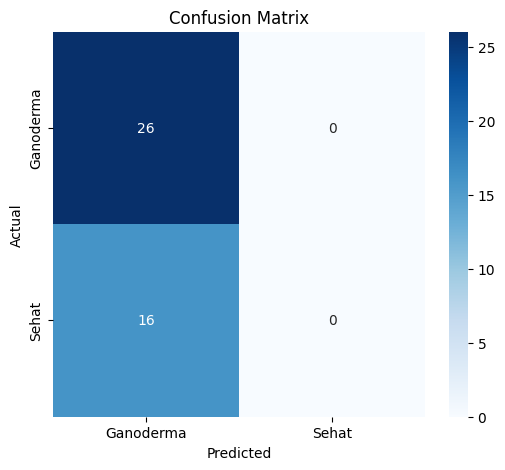


Classification Report:
              precision    recall  f1-score   support

   Ganoderma       0.62      1.00      0.76        26
       Sehat       0.00      0.00      0.00        16

    accuracy                           0.62        42
   macro avg       0.31      0.50      0.38        42
weighted avg       0.38      0.62      0.47        42



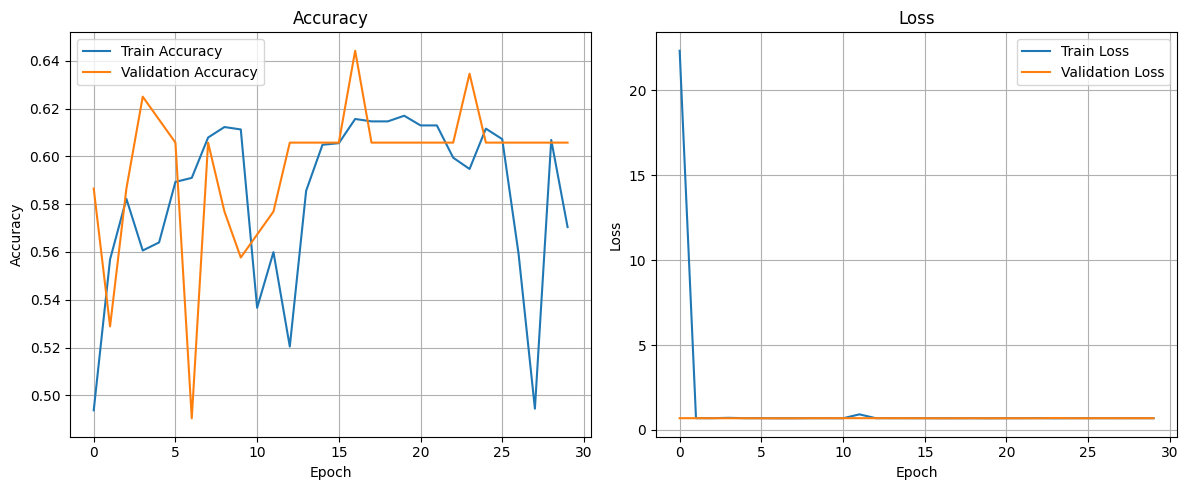

In [14]:
# ======================
# Evaluasi model
# ======================
y_true, y_pred = [], []

start_time = time.time()
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
end_time = time.time()
inference_time = (end_time - start_time) / len(y_true)

# Hitung metrik
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"Loss      : {test_loss:.4f}")
print(f"Rata-rata waktu inferensi per gambar: {inference_time:.4f} detik")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Grafik training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()